# Cut-in detection

In this notebook, the cut ins are detected. 

In [ ]:
# import cutin_detection

In [ ]:
%debug

In [2]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, kendalltau, spearmanr
from domain_model import StateVariable
from databaseemulator import DataBaseEmulator
from stats import KDE

In [3]:
# Load the database with the cut-in scenarios.
filename = os.path.join("data", "5_cutin_scenarios", "database.json")
DBE = DataBaseEmulator(filename)
print("Number of scenarios: {:d}".format(len(DBE.collections["scenario"])))

Number of scenarios: 298


In [4]:
def cutin_parameters(scenario):
    # Obtain the duration of the lane change.
    activity = next(activity for activity in scenario.activities 
                    if activity.activity_category.name == 'lane change target')
    duration = activity.tduration
    ystart = activity.get_state(time=scenario.time["start"])[0]
    yend = activity.get_state(time=scenario.time["end"])[0]
    tstart = activity.tstart
    from_direction = 'r' if activity.name == "left lane change" else 'r'
    
    # Obtain longitudinal speed/position at time of start cut in.
    vstart, vend = None, None
    xstart = None
    init_activity_target = ''
    for activity in scenario.activities:
        if activity.activity_category.state == StateVariable.LON_TARGET and \
                activity.tstart <= scenario.time["start"] <= activity.tend:
            vstart = activity.get_state(time=scenario.time["start"])[0][0]
            vend = activity.get_state(time=activity.tend)[0][0]
            xstart = activity.get_state(time=scenario.time["start"])[1][0]
            if activity.activity_category.name == "deceleration target":
                init_activity_target = 'd'
            elif activity.activity_category.name == "acceleration target":
                init_activity_target = 'a'
            else:
                init_activity_target = 'c'
            tstartlon = activity.tstart - scenario.time["start"]
            tendlin = activity.tend
            break
            
    # Obtain ego vehicle speed at time of start cut in.
    vego = None
    for actor, activity, _ in scenario.acts:
        if actor.name == "ego vehicle" and \
            activity.activity_category.state == StateVariable.SPEED and \
                activity.tstart <= scenario.time["start"] <= activity.tend:
            vego = activity.get_state(time=scenario.time["start"])[0]
            
    return [duration, ystart, yend, xstart, vstart, vego,
            from_direction, init_activity_target, tstartlon, tendlin]

In [5]:
# Get parameters of the cut-in: [duration, ystart, yend, xstart]
nscenarios = len(DBE.collections["scenario"])
#pars = [cutin_parameters(DBE.get_item("scenario", i)) for i in range(nscenarios)]
df = pd.DataFrame([cutin_parameters(DBE.get_item("scenario", i)) for i in range(nscenarios)], 
                  columns=['duration', 'ystart', 'yend', 'xstart', 'vstart', 'vego',
                           'from_direction', 'init_activity_target', 'tstartlon', 'tendlin'])
df["vdiff"] = df["vstart"] - df["vego"]
df["ystartabs"] = np.abs(df["ystart"])
df["yspeed"] = (df["yend"] - df["ystart"]) / df["duration"]
df["yspeedabs"] = np.abs(df["yspeed"])
df["tstartlonmap"] = np.log(-df["tstartlon"]+1)

# Plot a cut-in scenario

In [6]:
def plot_cutin(scenario, axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1)
        axes.plot(0, 0, 'gx')
    df = pd.DataFrame(index=np.arange(scenario.time["start"], scenario.time["end"], 0.01),
                      columns=["x", "y", "act"])
    activity = next(activity for activity in scenario.activities 
                    if activity.activity_category.name == 'lane change target')
    df["y"] = activity.get_state(time=df.index.values)
    
    for activity in scenario.activities:
        if activity.activity_category.state == StateVariable.LON_TARGET:
            if activity.tstart < df.index[0]:
                i = 0
            else:
                i = df.index.get_loc(activity.tstart, method='ffill')
            if activity.tend > df.index[-1]:
                j = len(df)
            else:
                j = df.index.get_loc(activity.tend, method='bfill')
            df.loc[df.index[i]:df.index[j-1], "x"] = \
                activity.get_state(time=np.array(df.index[i:j]))[1]
            if activity.activity_category.name == "acceleration target":
                df.loc[df.index[i]:df.index[j-1], "act"] = "a"
            elif activity.activity_category.name == "deceleration target":
                df.loc[df.index[i]:df.index[j-1], "act"] = "d"
            elif activity.activity_category.name == "cruising target":
                df.loc[df.index[i]:df.index[j-1], "act"] = "c"
            else:
                raise ValueError("Unknown longitudinal activity")
    for act, color in zip(["a", "d", "c"], ["g", "r", "b"]):
        mask = df["act"] == act
        if np.sum(mask):
            axes.plot(df.loc[mask, "x"], df.loc[mask, "y"], color=color)
    xmax = axes.get_xlim()[1]
    axes.set_xlim([-10, xmax])
    return axes

Text(0, 0.5, 'Lateral position [m]')

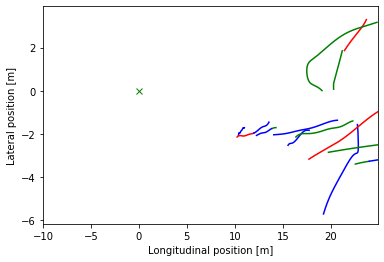

In [7]:
axes = plot_cutin(DBE.get_item("scenario", 0))
for i in range(1, 20):
    plot_cutin(DBE.get_item("scenario", i), axes=axes)
plt.xlabel("Longitudinal position [m]")
plt.ylabel("Lateral position [m]")

In [8]:
s = DBE.get_item("scenario", 39)
s.actors[1].properties

{'id': 2904, 'filename': 'data\\1_hdf5\\20170524_PP_02_Run_3.hdf5'}

# Step 1: Initial tags

In [9]:
for activity, abbr in zip(["acceleration", "deceleration", "cruising"], ["a", "d", "c"]):
    print("Probability of {:12s}: {:4.0f} %".
          format(activity, np.sum(df["init_activity_target"] == abbr)/nscenarios*100))

Probability of acceleration:   19 %
Probability of deceleration:   12 %
Probability of cruising    :   68 %


Furthermore, the initial lateral activity is always a lane change.

# Step 2: Initial parameters

The initial parameters consists of:

- `ystart`: Initial lateral position w.r.t. center lane of ego
- `xstart`: Initial longitudinal offset w.r.t. ego vehicle
- `tlongitudinal`: Time at which the longitudinal activity starts
- `vego`: Initial speed ego vehicle
- `vstart`: Initial speed target at the start of the scenario

In [149]:
# Determine if the parameters depend on the initial longitudinal activity.
def get_ks_result(act1, act2, signal):
    values1 = df.loc[df["init_activity_target"] == act1, signal].values
    values2 = df.loc[df["init_activity_target"] == act2, signal].values
    result = ks_2samp(values1, values2)
    return result.pvalue

print("     Variable  KS test")
print("                 a-d    a-c    d-c")
for signal in ['ystart', 'yend', 'tstartlon', 'tstartlonmap', 'ystartabs', 'vego', 'vstart']:
    print("{:>13s}".format(signal), end="")
    for act1, act2 in zip(["a", "a", "d"], ["d", "c", "c"]):
        print("  {:5.3f}".format(get_ks_result(act1, act2, signal)), end="")
    print("")

     Variable  KS test
                 a-d    a-c    d-c
       ystart  0.053  0.064  0.580
         yend  0.507  0.063  0.950
    tstartlon  0.021  0.001  0.049
 tstartlonmap  0.021  0.001  0.049
    ystartabs  0.003  0.079  0.105
         vego  0.026  0.442  0.027
       vstart  0.094  0.212  0.010


Based on the KS-test, `ystart` is significantly differently distributed in case of acceleration activities. Similarly, `yend` is significantly differently distributed for acceleration activities when compared to cruising activities. When comparing deceleration and cruising activities, the parameter `tstartlon` seems to be differently distributed.

In [151]:
def test_independent(data1, data2, verbose=False):
    data = np.concatenate((data1, data2))
    k, k1, k2 = KDE(data=data), KDE(data=data1), KDE(data=data2)
    k.compute_bandwidth(), k1.compute_bandwidth(), k2.compute_bandwidth()
    score1 = k.score_leave_one_out(include_const=True)
    score2 = (k1.score_leave_one_out(include_const=True) + 
              k2.score_leave_one_out(include_const=True))
    if verbose:
        print("1 KDE:  {:7.2f}".format(score1))
        print("2 KDes: {:7.2f}".format(score2))
    return score1, score2

print("     Variable  KDE test (positive means similarly distributed)")
print("                    a-d       a-c       d-c")
for signal in ['ystart', 'yend', 'tstartlonmap', 'vego', 'vstart']:
    print("{:>13s}".format(signal), end="")
    for act1, act2 in zip(["a", "a", "d"], ["d", "c", "c"]):
        data1 = df.loc[df["init_activity_target"] == act1, signal].values
        data1 /= np.std(df[signal])
        data2 = df.loc[df["init_activity_target"] == act2, signal].values
        data2 /= np.std(df[signal])
        score1, score2 = test_independent(data1, data2)
        print("  {:8.3f}".format(score1 - score2), end="")
    print("")

     Variable  KDE test (positive means similarly distributed)
                    a-d       a-c       d-c
       ystart    -7.597    -7.633     2.565
         yend    19.146    15.004    16.649
 tstartlonmap     0.001    -6.891    -7.236
         vego    -2.547    12.475    -2.219
       vstart    -9.406    -3.925    -1.651


In [148]:
def leave_one_out_score(data):
    kde = KDE(data=data)
    kde.compute_bandwidth()
    return kde.score_leave_one_out(include_const=True)
def compute_score(data, combinations):
    score = 0
    for combination in combinations:
        score += leave_one_out_score(data[:, combination])
    return score
print("a=ystart, b=xstart, c=tstartlon")
combinations = [([0, 1, 2],), ([0, 1], 2), ([0, 2], 1), (0, [1, 2]), (0, 1, 2)]
str_combinations = ['(a,b,c)', '(a,b),(c)', '(a,c),(b)', '(a),(b,c)', '(a),(b),(c)']
for act in ["a", "d", "c"]:
    print("Initial activity: {:s}".format(act))
    data = df.loc[df["init_activity_target"] == act, 
                  ["ystart", "xstart", "tstartlon"]].values
    data /= np.std(data, axis=0)
    scores = [compute_score(data, combination) for combination in combinations]
    i_best = np.argmax(scores)
    for i, (text, score) in enumerate(zip(str_combinations, scores)):
        print("{:>12s}:  {:.3e}{:>10s}".format(text, score, "Best!" if i==i_best else ""))

a=ystart, b=xstart, c=tstartlon
Initial activity: a
     (a,b,c):  -2.266e+02          
   (a,b),(c):  -2.046e+02          
   (a,c),(b):  -2.241e+02          
   (a),(b,c):  -1.782e+02          
 (a),(b),(c):  -1.742e+02     Best!
Initial activity: d
     (a,b,c):  -1.278e+02          
   (a,b),(c):  -1.257e+02          
   (a,c),(b):  -1.298e+02          
   (a),(b,c):  -1.274e+02          
 (a),(b),(c):  -1.233e+02     Best!
Initial activity: c
     (a,b,c):  -6.662e+02          
   (a,b),(c):  -5.892e+02          
   (a,c),(b):  -6.798e+02          
   (a),(b,c):  -5.992e+02          
 (a),(b),(c):  -5.874e+02     Best!


In [1]:
spearmanr(data[:, 0], data[:, 1])

NameError: name 'spearmanr' is not defined

Conclusion: The parameters `ystart`, `xstart` and `tstartlon` will be sampled independently from each other. Furthermore, a different KDE is used for each initial longitudinal activity.

But what would the result be if we go through all possibilities?

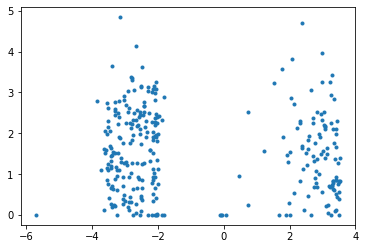

In [129]:
plt.plot(data[:, 0], data[:, 2], '.')

In [145]:
data = df[["ystart", "xstart", "tstartlonmap"]].values
for combination, str_combination in zip(combinations, str_combinations):
    print("{:>12s}: ".format(str_combination), end="")
    total = 0
    for c in combination:
        # Take all
        subdata = data[:, c]
        best = leave_one_out_score(subdata)
        print("{:7.1f} ".format(best))
        
        # Take acceleration apart
        subdata1 = data[:, c][df["init_activity_target"] == "a"]
        subdata2 = data[:, c][np.logical_not(df["init_activity_target"] == "a")]
        score = leave_one_out_score(subdata1) + leave_one_out_score(subdata2)
        print("{:7.1f} ".format(score))
        if score > best:
            best = score

     (a,b,c):    -inf 
   -inf 
   (a,b),(c):    -inf 
   -inf 
 -409.8 
 -404.9 
   (a,c),(b):  -897.0 
 -881.0 
   -inf 
   -inf 
   (a),(b,c):  -472.6 
 -464.0 
   -inf 
   -inf 
 (a),(b),(c):  -472.6 
 -464.0 
   -inf 
   -inf 
 -409.8 
 -404.9 


# Parameters activities

For the lane change, we have the parameters `yend` and `duration`. Alternatively, `yspeed` might be used instead of one of these.

For the longitudinal activity, we have the parameters `tend`, `vstart`, and `vend`. 

In [123]:
print("  Variable  KS test")
print("              a-d    a-c    d-c")
for signal in ['duration', 'yend', 'yspeed']:
    print("{:>10s}".format(signal), end="")
    for act1, act2 in zip(["a", "a", "d"], ["d", "c", "c"]):
        print("  {:5.3f}".format(get_ks_result(act1, act2, signal)), end="")
    print("")

  Variable  KS test
              a-d    a-c    d-c
  duration  0.776  0.759  0.447
      yend  0.507  0.063  0.950
    yspeed  0.030  0.070  0.689


In [ ]:
for act in ['a', 'd', 'c']:
    n = np.sum(df["init_activity_target"] == act)
    plt.plot(np.sort(df.loc[df["init_activity_target"] == act, "ystart"]),
             np.linspace(0, 1, n), label=act)
plt.legend()

In [ ]:
# See if the lane change data is correlated.
print(spearmanr(df["ystart"], df["duration"]))
print(kendalltau(df["ystart"], df["duration"]))
print(spearmanr(df["yend"], df["duration"]))
print(kendalltau(df["yend"], df["duration"]))
print(spearmanr(df["yend"], df["ystart"]))
print(kendalltau(df["yend"], df["ystart"]))

# Step 4: Next activity

In [152]:
# Compute 'transition' matrix
A = np.zeros((3, 3))  # 'a', 'd', 'c'
for i in range(nscenarios):
    s = DBE.get_item("scenario", i)
    t_acts = []
    lon_acts = []
    for actor, activity, tstart in s.acts:
        if actor.actor_category.name == "cut-in vehicle":
            if activity.activity_category.state == StateVariable.LON_TARGET:
                t_acts.append(tstart)
                lon_acts.append(activity)
    if len(t_acts) <= 1:
        continue
    i_sorted = np.argsort(t_acts)
    for i, j in zip(i_sorted[:-1], i_sorted[1:]):
        ia = (0 if lon_acts[i].activity_category.name == "acceleration target" else
              1 if lon_acts[i].activity_category.name == "deceleration target" else 2)
        ja = (0 if lon_acts[j].activity_category.name == "acceleration target" else
              1 if lon_acts[j].activity_category.name == "deceleration target" else 2)
        A[ia, ja] += 1

In [153]:
A

array([[ 0.,  3., 17.],
       [ 1.,  0.,  6.],
       [18., 14.,  0.]])